In [2]:
import torch
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
import requests
import os
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, auc
from scipy.spatial import KDTree
import pickle
import re

def canb_float(input_str):
  '''
  Using this function so that I can use the Paragraph read_pdb function.
  '''
  try:
    return eval(input_str)
  except ValueError:
    return False

def in_paratope(input, hl, ag):
  input['key'] = input['Res_Num'].map(str)+'_'+input['Chain']
  for x in ['x','y','z']:
    input[x] = input[x].map(canb_float)
    input = input[input[x]!=False]
  ag_resi = input[input['Chain'].isin(ag.split(';'))][['x','y','z']].values
  ab_resi = input[input['Chain'].isin(set(hl))]
  tree = KDTree(ag_resi)
  in_paratope = {}
  for k,p in ab_resi.groupby('key'):
    array =  p[['x','y','z']].values
    distance, values = tree.query(array, distance_upper_bound = 4.5)
    if np.where(distance != np.inf)[0].shape[0] != 0:
      in_paratope[k] = 1
    else:
      in_paratope[k] = 0
  return in_paratope

def summarize(x, key = 'pred'):
  p, r, _ = precision_recall_curve(x['label'], x[key])
  return {'roc':roc_auc_score(x['label'], x[key]), 'roc_10':roc_auc_score(x['label'],x[key],max_fpr=.1),
          'pr_auc':auc(r,p), 'p_hat':x['label'].sum()/x.shape[0]}


def download(pdb_id, output):
  out = requests.get(f'https://opig.stats.ox.ac.uk/webapps/sabdab-sabpred/sabdab/pdb/{pdb_id}/?scheme=imgt')
  summary = requests.get(f'https://opig.stats.ox.ac.uk/webapps/sabdab-sabpred/sabdab/summary/{pdb_id}/')
  with open(f'{output}/{pdb_id}.pdb', 'w') as k:
      k.write(out.content.decode())
  with open(f'{output}/{pdb_id}.tsv', 'w') as k:
      k.write(summary.content.decode())

In [ ]:
!git clone https://github.com/oxpig/Paragraph.git
%cd Paragraph/
!pip install .
from Paragraph.dataset import ParagraphDataset
from Paragraph.model import EGNN_Model
from Paragraph.predict import get_dataloader, evaluate_model

In [ ]:
training_set = pd.read_csv('training_data/PECAN/train_set.csv', header = None)
test_set = pd.read_csv('training_data/PECAN/test_set.csv', header = None)

pdb_path = 'pdbs'
if os.path.exists(pdb_path) is False:
  os.mkdir(pdb_path)
for k,p in tqdm(training_set.iterrows()):
  download(p[0].lower(), pdb_path)
for k,p in test_set.iterrows():
  download(p[0].lower(), pdb_path)

205it [06:28,  1.89s/it]


In [ ]:
num_feats = 22  # 20D one-hot encoding of AA type and 2D one-hot encoding of chain ID
saved_model_path = 'Paragraph/trained_model/pretrained_weights.pt'
graph_hidden_layer_output_dims = [num_feats]*6
linear_hidden_layer_output_dims = [10]*2
saved_net = EGNN_Model(num_feats = num_feats,
                      graph_hidden_layer_output_dims = graph_hidden_layer_output_dims,
                      linear_hidden_layer_output_dims = linear_hidden_layer_output_dims)
saved_net.load_state_dict(torch.load(saved_model_path, map_location = torch.device('cpu')))

<All keys matched successfully>

In [ ]:
if os.path.exists(f'training_set_paratopes.p') is False:
  paratope_labels = {}
  for k,p in tqdm(training_set.iterrows()):
    if p[0].lower() not in paratope_labels:
      input = format_pdb(os.path.join(pdb_path, f'{p[0].lower()}.pdb'))
      paratope_labels[p[0].lower()+'_'+p[1]+p[2]] = in_paratope(input, p[1]+p[2], p[3])
  with open(f'/content/drive/MyDrive/training_set_paratopes.p','wb') as k:
    pickle.dump(paratope_labels, k)

paratope_labels = pd.read_pickle(f'training_set_paratopes.p')
training_set = pd.read_csv('training_data/PECAN/train_set.csv', header = None)
training_set[0] = training_set[0].map(lambda x:x.lower())
marginal_frequency = {}
for k,p in tqdm(training_set.iterrows()):
  h = p[1]
  l = p[2]
  id = p[0]
  for res in paratope_labels[p[0]+'_'+h+l]:
    res, chain = res.split('_')
    chain_ = 'HL'[(h+l).index(chain)]
    if (chain_, res) not in marginal_frequency:
      marginal_frequency[(chain_, res)] = {'present':0, 'paratope':0}
    marginal_frequency[(chain_, res)] ['present'] += 1
    marginal_frequency[(chain_, res)] ['paratope'] += paratope_labels[p[0]+'_'+h+l][res+'_'+chain]
marginal_frequency = pd.DataFrame(marginal_frequency).T
marginal_frequency['value'] = marginal_frequency['paratope'] / marginal_frequency['present']
marginal_frequency_dict = dict(marginal_frequency['value'])



205it [00:00, 287.49it/s]


In [ ]:
test[0] = test[0].map(lambda x:x.lower())
test[[0,1,2]].to_csv('PECAN_abs.csv', header = None)
data_loader = get_dataloader('PECAN_abs.csv', pdb_path)
output = evaluate_model(saved_net, data_loader, device = 'cpu')
output['key'] = output['IMGT'].map(str) + '_' + output['chain_id']
output['label'] = output.apply(lambda x:paratope_labels[x['pdb']][x['key']], axis = 1)
output['marginal_freq'] = output.apply(lambda x:marginal_frequency_dict[(x.chain_type, x.IMGT)] if (x.chain_type, x.IMGT) in marginal_frequency_dict else 0, axis=1)
output = pd.read_csv('/content/drive/MyDrive/Paragraph_Output.csv', index_col = 0)

In [ ]:
performance_metrics = {}
performance_metrics['Marginal'] = {'ROC':roc_auc_score(output['label'], output['marginal_freq']), 'ROC_10':roc_auc_score(output['label'], output['marginal_freq'], max_fpr = .1),
                                   'PR-AUC':auc(*precision_recall_curve(output['label'], output['marginal_freq'])[:2][::-1])}
performance_metrics['SoTA'] = {'ROC':roc_auc_score(output['label'], output['pred']), 'ROC_10':roc_auc_score(output['label'], output['pred'], max_fpr = .1),
                                   'PR-AUC':auc(*precision_recall_curve(output['label'], output['pred'])[:2][::-1])}
performance_metrics = pd.DataFrame(performance_metrics)

In [ ]:
outputs = pd.DataFrame(dict(output.groupby('pdb').apply(lambda x:summarize(x)))).T.assign(Type='SoTA')
outputs['residual_pr_auc'] = outputs['pr_auc'] - outputs['p_hat']
outputs_ = pd.DataFrame(dict(output.groupby('pdb').apply(lambda x:summarize(x, 'marginal_freq')))).T.assign(Type='Marginal')
outputs_['residual_pr_auc'] = outputs_['pr_auc'] - outputs_['p_hat']
total_performance = pd.concat([outputs_,outputs])

In [ ]:

complexes = output['pdb'].unique()

subsampled_performance_sota = {}
subsampled_performance_marginal = {}
for subsample in range(1000):
  complexes_sub = set(np.random.choice(complexes, int(len(complexes)*0.9)))
  df = output[output['pdb'].isin(complexes_sub)]
  out = summarize(df)
  out_ = summarize(df, key = 'marginal_freq')
  subsampled_performance_sota[subsample] = out
  subsampled_performance_marginal[subsample] = out_

total_performance_subsample = pd.concat([pd.DataFrame(subsampled_performance_sota).T.assign(Type='SoTA'), pd.DataFrame(subsampled_performance_marginal).T.assign(Type='Baseline')])

outputs = pd.DataFrame(dict(output.groupby('pdb').apply(lambda x:summarize(x)))).T.assign(Type='SoTA')
outputs['residual_pr_auc'] = outputs['pr_auc'] - outputs['p_hat']
outputs_ = pd.DataFrame(dict(output.groupby('pdb').apply(lambda x:summarize(x, 'marginal_freq')))).T.assign(Type='Simple model')
outputs_['residual_pr_auc'] = outputs_['pr_auc'] - outputs_['p_hat']
total_performance_by_complex = pd.concat([outputs_,outputs])

In [ ]:
total_performance_subsample = pd.concat([pd.DataFrame(subsampled_performance_sota).T.assign(Type='SoTA'), pd.DataFrame(subsampled_performance_marginal).T.assign(Type='Simple model')]).reset_index()
random = total_performance_subsample[total_performance_subsample['Type']=='Simple model'].drop(['pr_auc','roc','roc_10'],axis=1).rename(columns={'p_hat':'pr_auc'}).assign(Type='Random')
total_performance_subsample = pd.concat([total_performance_subsample, random])

<ipython-input-166-3bd09514a2c8>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['ROC-AUC','ROC-AUC_0.1', 'PR-AUC', ], fontsize=14)


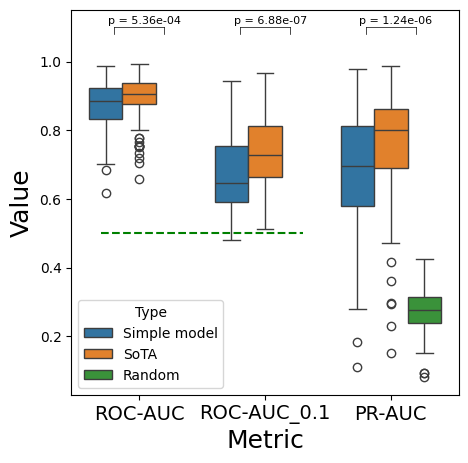

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

random = total_performance_by_complex[total_performance_by_complex['Type'] == 'Simple model'].drop(['pr_auc','roc','roc_10'],axis=1).rename(columns={'p_hat':'pr_auc'}).assign(Type='Random')
total_performance_flat = pd.concat([total_performance_by_complex, random]).melt(id_vars=['Type'], value_vars=['roc','pr_auc','roc_10'])
sns.boxplot(data = total_performance_flat, x = 'variable', y = 'value', hue = 'Type', order = ['roc', 'roc_10', 'pr_auc'])
ax.set_ylabel('Value', fontsize=18)
ax.set_xlabel('Metric', fontsize=18)
ax.set_xticklabels(['ROC-AUC','ROC-AUC_0.1', 'PR-AUC', ], fontsize=14)
from scipy.stats import wilcoxon
idx = 0
for key in ['roc','pr_auc','roc_10']:
  ax.plot([idx-0.2, idx+0.2], [1.1, 1.1], c = 'k', linewidth=.5)
  ax.plot([idx-0.2, idx-0.2], [1.08, 1.1], c = 'k', linewidth=.5)
  ax.plot([idx+0.2, idx+0.2], [1.08, 1.1], c = 'k', linewidth=.5)
  val, pval = wilcoxon(*total_performance.groupby('Type').apply(lambda x:x[key].values).values)
  ax.text(idx-0.25, 1.11, f'p = {pval:.2e}', fontsize=8)
  idx += 1
ax.plot([-0.3,1.3], [0.5,0.5],c='green',linestyle='--')

In [ ]:
def downsample_typeI(output, val):
  pos = output[output['label']==1]
  return pd.concat([output[output['label']==0].sample(int(pos.shape[0] * val), replace=True), pos])

def downsample_typeII(output, val, score):
  pos = output[output['label']==1]
  negative = output[(output['label']==0)]
  to_sample = int(val*pos.shape[0])
  lowest_score = output[output['label']==0][score].idxmin()
  lowest_score = output.loc[[lowest_score]*(to_sample-negative.shape[0])]
  return pd.concat([pos,negative, lowest_score])

In [ ]:
output['Label'] = output['label'].map(lambda x:'Negative' if x==0 else 'Positive')
example = downsample(output, 9)
example_typeII = downsample_typeII(output, 9, 'pred')

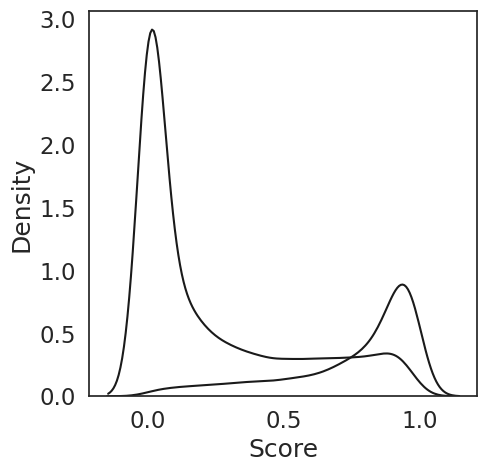

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax = sns.kdeplot(data = output.sort_values('label'), x = 'pred', hue = 'Label', fill=False, palette = ['k','k'])
ax.get_legend().remove()
ax.set_xlabel('Score')
plt.savefig('/content/drive/MyDrive/example.svg',format='svg')

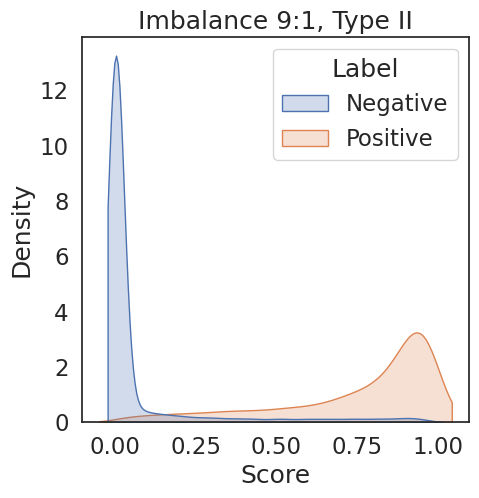

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax = sns.kdeplot(data = example_dumb.sort_values('label'), x = 'pred', hue = 'Label', fill=True, common_norm=False, cut = True)
ax.set_xlabel('Score')
plt.title('Imbalance 9:1, Type II')
plt.savefig('/content/drive/MyDrive/TypeII_imbalance.svg', format = 'svg')

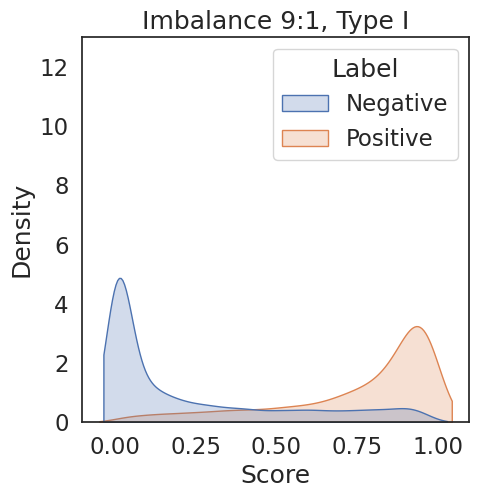

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax = sns.kdeplot(data = example.sort_values('label'), x = 'pred', hue = 'Label', fill=True, common_norm=False, cut = True)
ax.set_xlabel('Score')
plt.title('Imbalance 9:1, Type I')
ax.set_ylim(0,13)
plt.savefig('/content/drive/MyDrive/TypeI_imbalance.svg', format = 'svg')

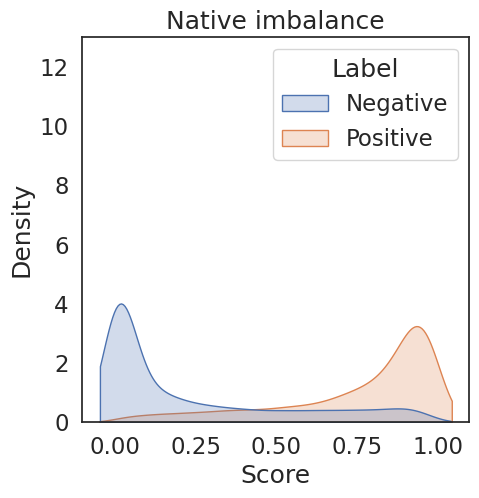

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax = sns.kdeplot(data = output.sort_values('label'), x = 'pred', hue = 'Label', fill=True, common_norm=False, cut = True)
ax.set_xlabel('Score')
plt.title('Native imbalance')
ax.set_ylim(0,13)
plt.savefig('/content/drive/MyDrive/native_imbalance.svg', format = 'svg')

In [ ]:
scores = {}
scores_mapping = {9:'1:9', 99:'1:99', 1:'1:1'}
for p in [99, 9]:
    down = downsample_dumb(output, p, 'pred')
    summary = summarize(down)
    scores[scores_mapping[p]] = summary
scores['Native'] = summarize(output)
total_typeII = pd.DataFrame(scores).T.reset_index().rename(columns={'index':'Imbalance'})
# total = pd.concat([total[p].reset_index().rename(columns={'index':'Imbalance'}).assign(Repeat=p) for p in total])

In [ ]:
total = {}
scores_mapping = {9:'1:9', 99:'1:99', 1:'1:1'}
for repeat in range(100):
  scores = {}
  for p in [99, 9, 1]:
      down = downsample(output, p)
      summary = summarize(down)
      scores[scores_mapping[p]] = summary
  total[repeat] = pd.DataFrame(scores).T
total = pd.concat([total[p].reset_index().rename(columns={'index':'Imbalance'}).assign(Repeat=p) for p in total])
total = pd.concat([total, pd.DataFrame({'Native':summarize(output)}).T.reset_index().rename(columns={'index':'Imbalance'})])
total.to_csv('/content/drive/MyDrive/subsamples_total.csv')

<ipython-input-53-d41211011830>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = total_dumb, x = 'Imbalance', y = 'roc', ax = ax[0], palette=palette, edgecolor = 'k')
<ipython-input-53-d41211011830>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = total_dumb, x = 'Imbalance', y = 'roc_10', ax = ax[1], palette=palette, edgecolor = 'k')
<ipython-input-53-d41211011830>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = total_dumb, x = 'Imbalance', y = 'pr_auc', ax = ax[2],palette=palette, edgecolor = 'k')


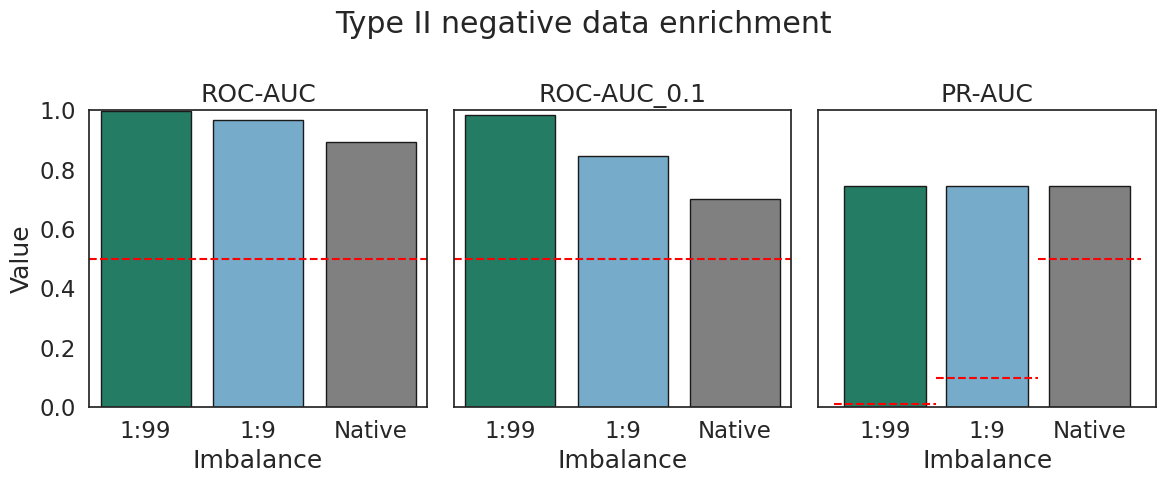

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,5),sharey=True)
plt.suptitle('Type II negative data enrichment')
palette = ['#178A6A', '#68AFD7', 'grey']
sns.barplot(data = total_dumb, x = 'Imbalance', y = 'roc', ax = ax[0], palette=palette, edgecolor = 'k')
sns.barplot(data = total_dumb, x = 'Imbalance', y = 'roc_10', ax = ax[1], palette=palette, edgecolor = 'k')
sns.barplot(data = total_dumb, x = 'Imbalance', y = 'pr_auc', ax = ax[2],palette=palette, edgecolor = 'k')
ax[0].set_ylabel('Value')
ax[0].set_title('ROC-AUC')
ax[1].set_title('ROC-AUC_0.1')
ax[2].set_title('PR-AUC')
ax[2].plot([-.5, .5], [1/100, 1/100], c='red', linestyle='--')
ax[2].plot([.5, 1.5], [1/10, 1/10], c='red', linestyle='--')
ax[2].plot([1.5, 2.5], [1/2, 1/2], c='red', linestyle='--')
ax[0].axhline(0.5, c='red',linestyle='--')
ax[1].axhline(0.5, c='red',linestyle='--')
fig.tight_layout()
ax[0].set_ylim(0,1)
plt.savefig('/content/drive/MyDrive/typeII_results.svg', format='svg')

<ipython-input-54-3ed81ad51634>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = total, x = 'Imbalance', y = 'roc', ax = ax[0], palette=palette)
<ipython-input-54-3ed81ad51634>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = total, x = 'Imbalance', y = 'roc_10', ax = ax[1], palette=palette)
<ipython-input-54-3ed81ad51634>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = total, x = 'Imbalance', y = 'pr_auc', ax = ax[2],palette=palette)


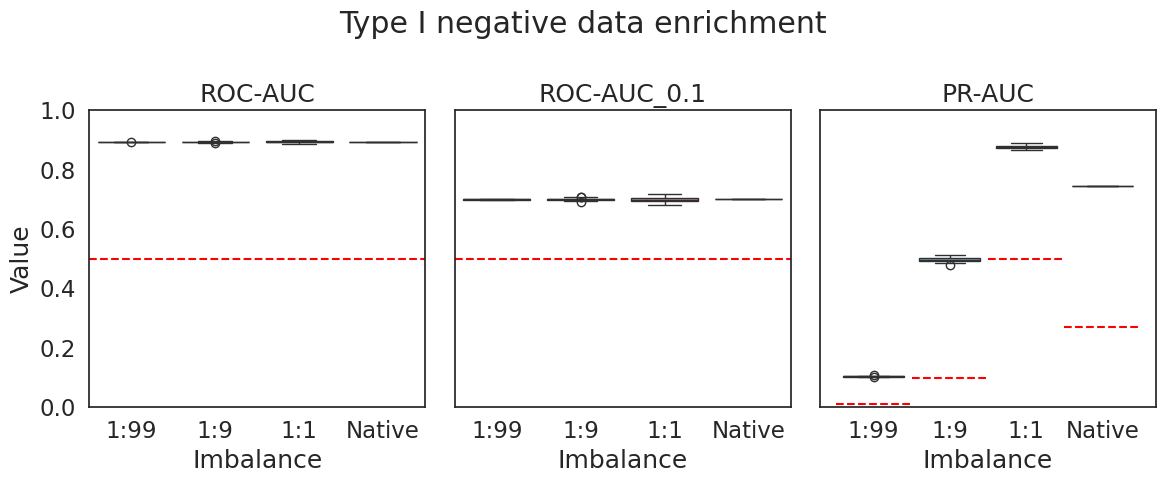

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,5),sharey=True)
plt.suptitle('Type I negative data enrichment')
palette = ['#178A6A', '#68AFD7', '#C283A6', 'red']
sns.boxplot(data = total, x = 'Imbalance', y = 'roc', ax = ax[0], palette=palette)
sns.boxplot(data = total, x = 'Imbalance', y = 'roc_10', ax = ax[1], palette=palette)
sns.boxplot(data = total, x = 'Imbalance', y = 'pr_auc', ax = ax[2],palette=palette)
ax[0].set_ylabel('Value')
ax[0].set_title('ROC-AUC')
ax[1].set_title('ROC-AUC_0.1')
ax[2].set_title('PR-AUC')
ax[2].plot([-.5, .5], [1/100, 1/100], c='red', linestyle='--')
ax[2].plot([.5, 1.5], [1/10, 1/10], c='red', linestyle='--')
ax[2].plot([1.5, 2.5], [1/2, 1/2], c='red', linestyle='--')
ax[2].plot([2.5, 3.5], [.27, .27], c='red', linestyle='--')
ax[0].axhline(0.5, c='red',linestyle='--')
ax[1].axhline(0.5, c='red',linestyle='--')
fig.tight_layout()
ax[0].set_ylim(0,1)
plt.savefig('/content/drive/MyDrive/typeI_results.svg', format='svg')

<ipython-input-120-14b621113a9d>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['ROC-AUC','ROC-AUC_0.1', 'PR-AUC', ], fontsize=14)


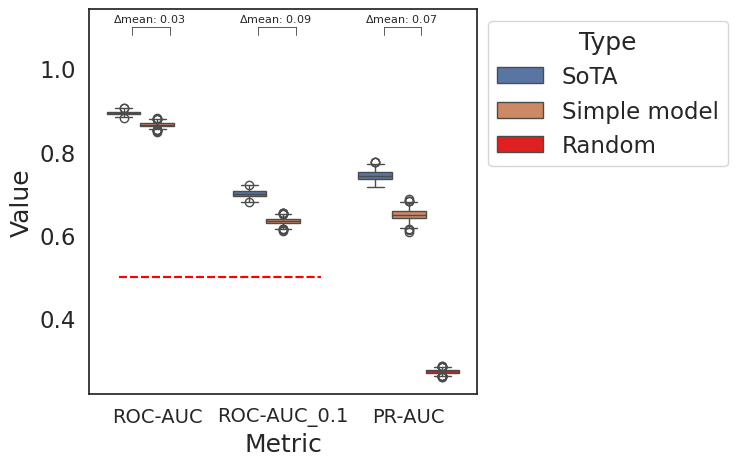

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.boxplot(data = total_performance_subsample.melt(id_vars=['Type'], value_vars=['roc','pr_auc','roc_10']), x = 'variable', y = 'value', hue = 'Type', order = ['roc', 'roc_10', 'pr_auc'], palette=['C0','C1','red'])
ax.set_ylabel('Value', fontsize=18)
ax.set_xlabel('Metric', fontsize=18)
ax.set_xticklabels(['ROC-AUC','ROC-AUC_0.1', 'PR-AUC', ], fontsize=14)
ax.plot([-0.3,1.3],[0.5,0.5],c='red', linestyle='--')
sns.move_legend(ax, bbox_to_anchor=(1,1), loc='upper left')
from scipy.stats import wilcoxon, mannwhitneyu
idx = 0
for key in ['roc','pr_auc','roc_10']:
  ax.plot([idx-0.2, idx+0.1], [1.1, 1.1], c = 'k', linewidth=.5)
  ax.plot([idx-0.2, idx-0.2], [1.08, 1.1], c = 'k', linewidth=.5)
  ax.plot([idx+0.1, idx+0.1], [1.08, 1.1], c = 'k', linewidth=.5)
  val, pval = mannwhitneyu(*total_performance_subsample[total_performance_subsample['Type']!='Random'].groupby('Type').apply(lambda x:x[key].values).values)
  mean_diff = np.mean(total_performance_subsample[total_performance_subsample['Type']=='SoTA'][key].values)
  simple_diff = np.mean(total_performance_subsample[total_performance_subsample['Type']=='Simple model'][key].values)
  ax.text(idx-.35, 1.11, r'$\Delta$mean: '+f'{(mean_diff-simple_diff):.2f}', fontsize=8)
  idx += 1
ax.plot([-0.3,1.3], [0.5,0.5],c='red',linestyle='--')
plt.savefig('/content/drive/MyDrive/SOTA_v_simple.svg', format = 'svg')

In [ ]:
def plot_pr_and_roc(output):
  fig, ax = plt.subplots(1,1,figsize=(5,5))
  p, r, _ = precision_recall_curve(output['label'], output['pred'])
  auc_ = auc(r, p)
  ax.plot(r,p)
  ax.text(0.6, 0.95, f'AUC: {auc_:.2f}', c='C0')
  p, r, _ = precision_recall_curve(output['label'], output['marginal_freq'])
  ax.plot(r,p)
  auc_ = auc(r, p)
  ax.text(0.6, 0.9, f'AUC: {auc_:.2f}', c='C1')
  ax.axhline(output['label'].sum()/output.shape[0], c = 'red', linestyle ='--')
  plt.legend(['SoTA', 'Simple model', 'Random'])
  ax.set_ylabel('Precision',fontsize=18)
  ax.set_xlabel('Recall', fontsize=18)
  ax.set_title('PR Curve', fontweight='bold', fontsize=18)
  sns.move_legend(ax, bbox_to_anchor=(1,1), loc='upper left')
  fig, ax = plt.subplots(1,1,figsize=(5,5))
  p, r, _ = roc_curve(output['label'], output['pred'])
  auc_ = auc(p, r)
  ax.plot(p, r)
  ax.text(0.6, 0.95, f'AUC: {auc_:.2f}', c='C0')
  p, r, _ = roc_curve(output['label'], output['marginal_freq'])
  auc_ = auc(p, r)
  ax.plot(p,r)
  ax.text(0.6, 0.87, f'AUC: {auc_:.2f}', c='C1')
  ax.plot([0,1],[0,1],linestyle ='--',c='red')
  plt.legend(['SoTA', 'Simple model', 'Random'])
  ax.set_ylabel('TPR',fontsize=18)
  plt.title('ROC curve', fontweight='bold',fontsize=18)
  ax.set_xlabel('FPR',fontsize=18)
  ax.get_legend().remove()

  fig, ax = plt.subplots(1,1,figsize=(5,5))
  tpr, fpr, _ = roc_curve(output['label'], output['pred'])
  df = pd.DataFrame([tpr,fpr,_]).T
  auc_ = roc_auc_score(output['label'], output['pred'], max_fpr = .1)
  sns.lineplot(data = df[df[0]<=.1], x=0,y=1)
  ax.text(0.06, 0.6, f'AUC: {auc_:.2f}', c='C0')
  tpr, fpr, _ = roc_curve(output['label'], output['marginal_freq'])
  df = pd.DataFrame([tpr,fpr,_]).T
  auc_ = roc_auc_score(output['label'], output['marginal_freq'], max_fpr = .1)
  sns.lineplot(data = df[df[0]<=.1], x=0,y=1)
  ax.text(0.06, 0.55, f'AUC: {auc_:.2f}', c='C1')
  ax.plot([0,.1],[0,.1],linestyle ='--',c='red')
  plt.legend(['SoTA', 'Simple model', 'Random'])
  ax.set_ylabel('TPR',fontsize=18)
  plt.title('ROC_0.1 curve', fontweight='bold',fontsize=18)
  ax.set_xlabel('FPR',fontsize=18)
  ax.get_legend().remove()

In [ ]:
def plot_pr_and_roc(output):
  fig, ax = plt.subplots(1,3,figsize=(15,5))
  p, r, _ = precision_recall_curve(output['label'], output['pred'])
  p = list(p)
  r = list(r)
  auc_ = auc(r, p)
  ax[0].plot([1] + r,[0] + p)
  ax[0].text(0.6, 0.95, f'AUC: {auc_:.2f}', c='C0')
  p, r, _ = precision_recall_curve(output['label'], output['marginal_freq'])
  p = list(p)
  r = list(r)
  ax[0].plot([1] + r,[0] + p)
  auc_ = auc(r, p)
  ax[0].text(0.6, 0.9, f'AUC: {auc_:.2f}', c='C1')
  ax[0].axhline(output['label'].sum()/output.shape[0], c = 'red', linestyle ='--')
  ax[0].legend(['SoTA', 'Simple model', 'Random'])
  ax[0].set_ylabel('Precision',fontsize=18)
  ax[0].set_xlabel('Recall', fontsize=18)
  ax[0].set_title('PR Curve', fontweight='bold', fontsize=18)
  sns.move_legend(ax[0], bbox_to_anchor=(1,1), loc='upper right')
  p, r, _ = roc_curve(output['label'], output['pred'])
  auc_ = auc(p, r)
  ax[1].plot(p, r)
  ax[1].text(0.6, 0.95, f'AUC: {auc_:.2f}', c='C0')
  p, r, _ = roc_curve(output['label'], output['marginal_freq'])
  auc_ = auc(p, r)
  ax[1].plot(p,r)
  ax[1].text(0.6, 0.87, f'AUC: {auc_:.2f}', c='C1')
  ax[1].plot([0,1],[0,1],linestyle ='--',c='red')
  plt.legend(['SoTA', 'Simple model', 'Random'])
  ax[1].set_ylabel('TPR',fontsize=18)
  ax[1].set_title('ROC curve', fontweight='bold',fontsize=18)
  ax[1].set_xlabel('FPR',fontsize=18)

  tpr, fpr, _ = roc_curve(output['label'], output['pred'])
  df = pd.DataFrame([tpr,fpr,_]).T
  auc_ = roc_auc_score(output['label'], output['pred'], max_fpr = .1)
  sns.lineplot(data = df[df[0]<=.1], x=0,y=1)
  ax[2].text(0.06, 0.6, f'AUC: {auc_:.2f}', c='C0')
  tpr, fpr, _ = roc_curve(output['label'], output['marginal_freq'])
  df = pd.DataFrame([tpr,fpr,_]).T
  auc_ = roc_auc_score(output['label'], output['marginal_freq'], max_fpr = .1)
  sns.lineplot(data = df[df[0]<=.1], x=0,y=1, ax=ax[2])
  ax[2].text(0.06, 0.55, f'AUC: {auc_:.2f}', c='C1')
  ax[2].plot([0,.1],[0,.1],linestyle ='--',c='red')
  plt.legend(['SoTA', 'Simple model', 'Random'])
  ax[2].set_ylabel('TPR',fontsize=18)
  plt.title('ROC_0.1 curve', fontweight='bold',fontsize=18)
  ax[2].set_xlabel('FPR',fontsize=18)
  ax[2].get_legend().remove()
  fig.tight_layout()

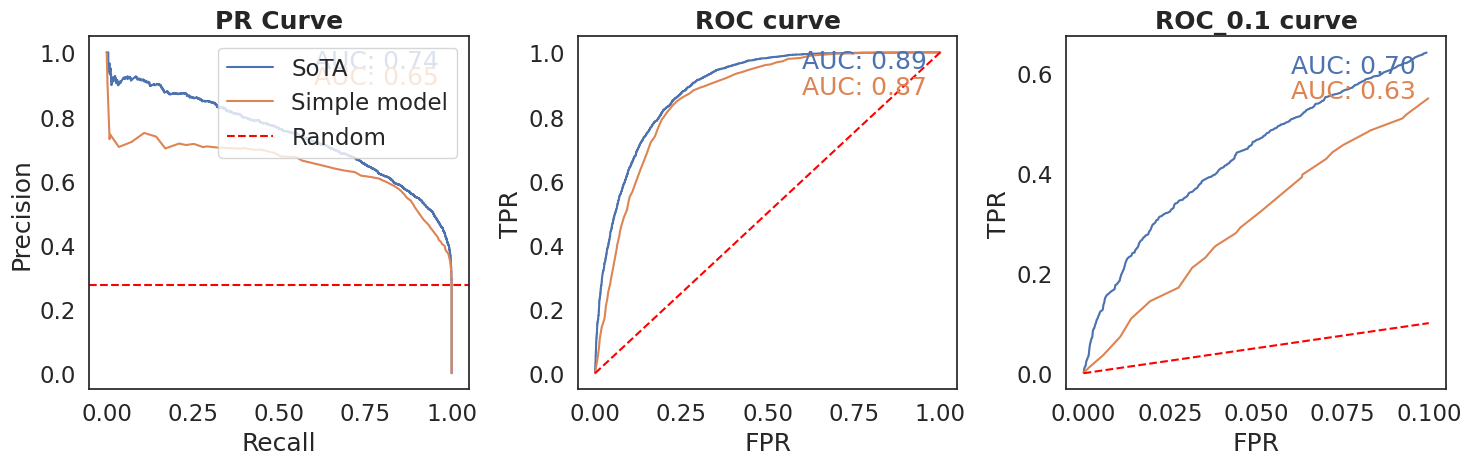

In [ ]:
plot_pr_and_roc(output)
plt.savefig('/content/drive/MyDrive/PR_ROC_paragraph.svg', format = 'svg')

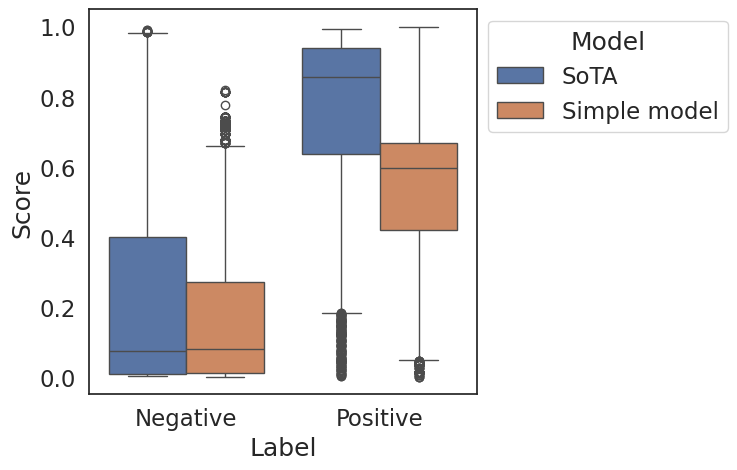

In [ ]:
sns.set(style='white',font_scale=1.5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
f = output.melt(id_vars=['label'],value_vars=['pred','marginal_freq'])
f['Model'] = f['variable'].map(lambda x:'SoTA' if x=='pred' else 'Simple model')
sns.boxplot(data =f, x='label', y = 'value', hue = 'Model',ax=ax)
sns.move_legend(ax, bbox_to_anchor=(1,1), loc='upper left')
ax.get_legend().set_title('Model')
ax.set_xlabel('Label')
ax.set_ylabel('Score')
ax.set_xticks([0,1],['Negative', 'Positive'])

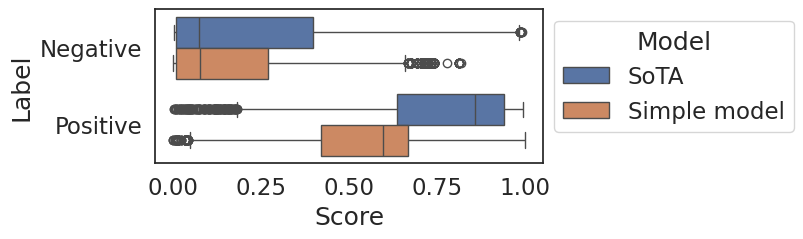

In [ ]:
sns.set(style='white',font_scale=1.5)
fig, ax = plt.subplots(1,1, figsize=(5,2))
f = output.melt(id_vars=['label'],value_vars=['pred','marginal_freq'])
f['Model'] = f['variable'].map(lambda x:'SoTA' if x=='pred' else 'Simple model')
f['label'] = f['label'].map(str)
sns.boxplot(data = f, y='label', x = 'value', hue = 'Model',ax=ax)
sns.move_legend(ax, bbox_to_anchor=(1,1), loc='upper left')
ax.get_legend().set_title('Model')
ax.set_ylabel('Label')
ax.set_xlabel('Score')
ax.set_yticks([0,1],['Negative', 'Positive'])
plt.savefig('/content/drive/MyDrive/SOTA_v_simple_scores.svg', format = 'svg')

Text(0.5, 1.0, 'Random PR-AUC vs. model PR-AUC')

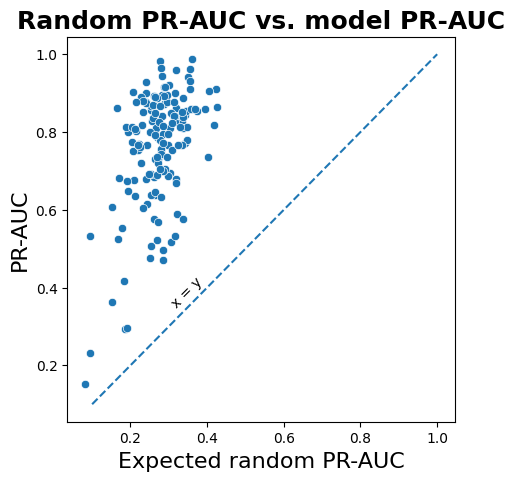

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.scatterplot(data = outputs, x = 'p_hat', y = 'pr_auc', ax = ax)
ax.plot([0.1,1],[0.1,1], '--')
ax.set_xlabel('Expected random PR-AUC', fontsize=16)
ax.set_ylabel('PR-AUC', fontsize=16)
ax.text(0.3, 0.35, s='x = y', rotation=45)
# ax.plot([0,1],[0,1])
ax.set_title('Random PR-AUC vs. model PR-AUC', fontweight='bold', size=18)

Text(0.5, 1.0, 'ROC-AUC vs. PR-AUC')

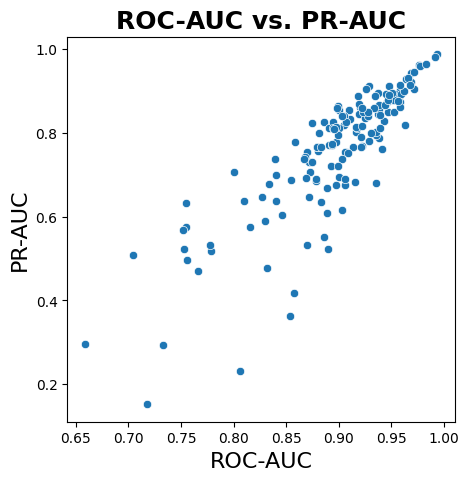

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.scatterplot(data = outputs, x = 'roc', y = 'pr_auc', ax = ax)
# ax.plot([0.1,1],[0.1,1], '--')
ax.set_xlabel('ROC-AUC', fontsize=16)
ax.set_ylabel('PR-AUC', fontsize=16)
# ax.text(0.3, 0.35, s='x = y', rotation=45)
# ax.plot([0,1],[0,1])
ax.set_title('ROC-AUC vs. PR-AUC', fontweight='bold', size=18)

Text(0.5, 1.0, 'ROC-AUC vs. PR-AUC')

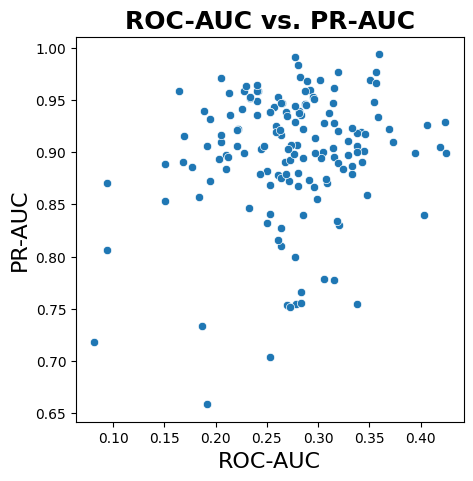

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.scatterplot(data = outputs, x = 'p_hat', y = 'roc', ax = ax)
# ax.plot([0.1,1],[0.1,1], '--')
ax.set_xlabel('ROC-AUC', fontsize=16)
ax.set_ylabel('PR-AUC', fontsize=16)
# ax.text(0.3, 0.35, s='x = y', rotation=45)
# ax.plot([0,1],[0,1])
ax.set_title('ROC-AUC vs. PR-AUC', fontweight='bold', size=18)

Text(0.5, 1.0, 'ROC-AUC vs. PR-AUC')

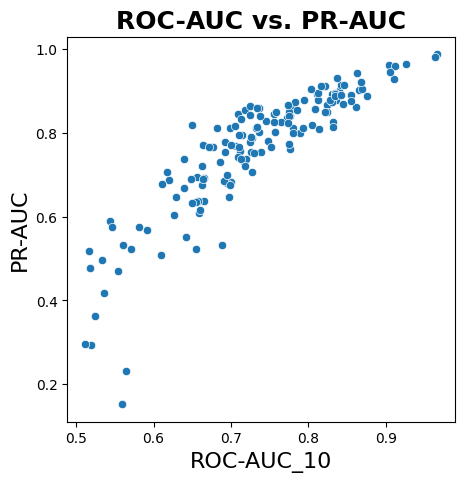

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.scatterplot(data = outputs, x = 'roc_10', y = 'pr_auc', ax = ax)
# ax.plot([0.1,1],[0.1,1], '--')
ax.set_xlabel('ROC-AUC_10', fontsize=16)
ax.set_ylabel('PR-AUC', fontsize=16)
# ax.text(0.3, 0.35, s='x = y', rotation=45)
# ax.plot([0,1],[0,1])
ax.set_title('ROC-AUC vs. PR-AUC', fontweight='bold', size=18)